In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, scipy
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
df = pd.read_csv('sentiment_data_analytic_vidya.csv')
df['tweet'] = df['tweet'].map(lambda x : x.lower())
df.head(3)

,id,label,tweet
0,1,0,#fingerprint #pregnancy test https://goo.gl/h1...
1,2,0,finally a transparant silicon case ^^ thanks t...
2,3,0,we love this! would you go? #talk #makememorie...


In [0]:
df.shape

(7920, 3)

In [0]:
df1 = df.copy()

In [0]:
def punch(x):
    x = re.sub(r"[-()\"#/@;:@*<>{}`ð'+=~£|¦â.!%+-^$?,0-9]","", x)
    x = re.sub('$&@*#', 'vulgar', x) # Mention in data 
    x = re.sub(r"(\d+)(k)", r"\g<1>000", x) #expand 'k' to '000' eg. 50k to 50000
    x = re.sub("\\n", ' ', x)
    x = re.sub("\W", ' ', x)
    x = re.sub("\'s", " ", x) 
    x = re.sub("whats", "what is", x, flags=re.IGNORECASE)
    x = re.sub("\'ve", "have", x)
    x = re.sub("can't", "can not", x)
    x = re.sub("n't", "not", x)
    x = re.sub("i'm", "i am", x, flags = re.IGNORECASE)
    x = re.sub("\'re", "are", x)
    x = re.sub("\'d", "would", x)
    x = re.sub(r"http\S+", "", str(x))
    x = re.sub("e\.g\.", "eg", x, flags = re.IGNORECASE)
    x = re.sub("e-mail", "email", x, flags = re.IGNORECASE)
    x = re.sub(r"e - mail", "email", x)
    x = re.sub(r"US", "America", x)
    x = re.sub(r"USA", "America", x)
    x = re.sub(r"us", "America", x)
    x = re.sub(r"usa", "America", x)
    x = re.sub(r"Chinese", "China", x)
    x = re.sub(r"india", "India", x)
    x = re.sub("im", "i am", x, flags = re.IGNORECASE)
    x = re.sub("its", "it is", x, flags= re.IGNORECASE)
    x = re.sub("shes", "she is", x, flags = re.IGNORECASE)
    x = re.sub("u", "you", x, flags = re.IGNORECASE)
    x = re.sub("ur", "you are", x, flags = re.IGNORECASE)
    x = re.sub("wouldnt", "would not", x, flags = re.IGNORECASE)
    x = re.sub("youve",  "you have", x, flags = re.IGNORECASE)
    x = re.sub(r"\s{2,}", " ", x) # Remove extra space between words
    x = x.strip() # Remove extra space from begning and ending
    
    return(x)

df1['tweet'] = df1['tweet'].map(lambda x : punch(x))

In [0]:
def remove_stopwords(x):
    return(' '.join([word for word in nltk.word_tokenize(x) if word not in stopwords.words('english')]))

def get_char_length_ratio(x): #To find how much word has meaningful content
    return len(x['tweet'])/max(1,len(x['tweet_without_stop_words']))

def get_Levenshtein(string1,string2): # Calculate Levenshtein distance to measure similiarity between string(edit base)
    import editdistance
    return editdistance.eval(string1,string2)

In [0]:
df1['tweet_without_stop_words'] = df1['tweet'].map(lambda x : remove_stopwords(x))
df1['char_length_ratio'] = df1.apply(lambda x : get_char_length_ratio(x), axis = 1)
df1['leve_distance'] = df1.apply(lambda x : get_Levenshtein(x['tweet'], x['tweet_without_stop_words']), axis = 1)

In [0]:
def lemitize(x):
  lemmatizer = WordNetLemmatizer()
  return(' '.join([lemmatizer.lemmatize(word)  for word in nltk.word_tokenize(x)]))
df1['lemitized words'] = df1['tweet_without_stop_words'].map(lambda x : lemitize(x)) 

In [0]:
## Lexicon model based rating:-
from nltk.corpus import opinion_lexicon
nltk.download('opinion_lexicon')
pos_list = set(opinion_lexicon.positive())
neg_list = set(opinion_lexicon.negative())

sentiment = []
for x in df1['tweet_without_stop_words']:
    marks = 0
    for j in nltk.word_tokenize(x):
        if j in pos_list:
            marks += 1
        elif j in neg_list:
            marks -= 1
    sentiment.append(marks)
df1['lexicon_rating'] = sentiment

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [0]:
tfidf = TfidfVectorizer(stop_words = 'english', max_df = 0.99, strip_accents = 'unicode', ngram_range=(1, 1), min_df = 5) # n_gram range(1,2), (1,4) not improving accurecy
temp = tfidf.fit_transform(df1['tweet']) #Remove stop words by self 
temp

<7920x2276 sparse matrix of type '<class 'numpy.float64'>'
	with 66610 stored elements in Compressed Sparse Row format>

In [0]:
df1_new = pd.DataFrame(temp.toarray())
df1_new['char_length_ratio'] = df1['char_length_ratio']
df1_new['leve_distance'] = df1['leve_distance']
df1_new['lexicon_rating'] = df1['lexicon_rating']
df1_new['label'] = df1['label']

df1_new.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2240,2241,2242,2243,2244,2245,2246,2247,2248,2249,2250,2251,2252,2253,2254,2255,2256,2257,2258,2259,2260,2261,2262,2263,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,char_length_ratio,leve_distance,lexicon_rating,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.131579,10,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.195124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.091954,8,1,0


In [0]:
df1_new.shape

(7920, 2280)

In [0]:
x_dev, x_final, y_dev, y_final = train_test_split(df1_new.iloc[:,:-1], df1_new['label'], test_size = 0.08, random_state = 42)
x_train, x_test, y_train, y_test = train_test_split(x_dev, y_dev, test_size = 0.2, random_state = 42)

In [0]:
x_dev.shape,x_final.shape

((7286, 2279), (634, 2279))

In [0]:
x_train.shape, y_train.shape

((5828, 2279), (5828,))

In [0]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators = 430,
                       n_jobs=None, oob_score = True, random_state=42, verbose=0,
                       warm_start= True)
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=430,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=True)

In [0]:
model.fit(x_train, y_train)
pred = model.predict(x_test)

y_pred = []
for i in pred:
    if i <= 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

f1_score(y_test, np.array(y_pred).reshape(y_test.shape))
# 0.76649 (1, 1) min_df = 3
# 0.775 min_df = 5

0.7772277227722771

In [0]:
confusion_matrix(y_test, y_pred)

array([[545,  34],
       [ 56, 157]])

In [0]:
x_train.shape, x_test.shape

((7128, 2279), (792, 2279))

In [0]:
############         ANN             #############

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout

# To avoid randomness:- It is not totally removing the result difference problem of every iteration only 
# reducing some difference or can say some values are fixed, and some are also changing so by fixing some
# by using these It settle down.
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

result = 0

for i in range(0,3):
  model = Sequential()
  model.add(Dense(800, input_dim = 2279, activation= 'relu'))  # 500, 500, 1, 64
  model.add(Dropout(0.1))
  model.add(Dense(500, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  from keras.wrappers.scikit_learn import KerasClassifier
  import keras.backend as K

  def get_f1(y_true, y_pred): #taken from old keras source code
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      recall = true_positives / (possible_positives + K.epsilon())
      f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
      return f1_val

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[get_f1])
  # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # l = [5, 10,  50]

  history = model.fit(x_train, y_train, epochs = 5 , batch_size = 32, verbose = 0)

  pred = model.predict(x_test)

  y_pred = []
  for i in pred:
    if i <= 0.5:
      y_pred.append(0)
    else:
      y_pred.append(1)

  print(f1_score(y_test, np.array(y_pred).reshape(y_test.shape)))
  result += f1_score(y_test, np.array(y_pred).reshape(y_test.shape))

  confusion_matrix(y_test, y_pred)
print('Avg:-', result/5)

0.7660668380462724
0.7571801566579635
0.764857881136951
Avg:- 0.45762097516823735


In [0]:
pred = model.predict(x_final)

y_pred = []
for i in pred:
  if i <= 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

print(f1_score(y_final, np.array(y_pred).reshape(y_final.shape)))

0.7963525835866262


In [0]:
## Result:-
1.epochs = 5, F1-Score = 0.8245
  model.add(Dense(800, input_dim = 2279, activation='relu'))

  model.add(Dense(300, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

2. epochs = 5, batch = 16, f1 = 0.8018, layer = [500, 500, 1], activation = ['relu', 'relu', 'sigmoid']
3. epochs = 5, batch = 16, f1 = 0.813, layer = [500, 500, 1], activation = ['sigmoid', 'sigmoid', 'sigmoid']
3. epochs = 5, batch = 64, f1 = 0.800, layer = [800, 800, 1], activation = ['sigmoid', 'sigmoid', 'sigmoid']


In [0]:
########################       LSTM         #########################

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.layers import SpatialDropout1D, Dropout
from keras.layers import Dense, Embedding


In [0]:
l = []
for i in df1['tweet_without_stop_words']:
  l.extend(nltk.word_tokenize(i))
print(len(set(l)))  # Total words

# tf-idf helps to find no of top important(Occuring) words(min_df, max_df) which use as max_feature:
tfidf = TfidfVectorizer(stop_words = 'english', max_df = 0.99, strip_accents = 'unicode', ngram_range=(1, 1), min_df = 5) # n_gram range(1,2), (1,4) not improving accurecy
temp = tfidf.fit_transform(df1['tweet']) #Remove stop words by self 
temp

# So we take approx 2280 words 

17697


<7920x2276 sparse matrix of type '<class 'numpy.float64'>'
	with 66610 stored elements in Compressed Sparse Row format>

In [0]:
# Tokenize and Create Sequence
max_fatures = 2280            # top 2000 words
tokenizer = Tokenizer(num_words = max_fatures, split=' ')
tokenizer.fit_on_texts(df1['tweet_without_stop_words'].values)

df1_int_data = tokenizer.texts_to_sequences(df1['tweet_without_stop_words'].values) # Change text into integer
df1_int_data[:5]

[[2072, 1213, 15, 63, 40, 21, 102, 78, 91, 84, 1],
 [56, 33, 74, 195, 7, 238],
 [11, 79, 5, 99, 837, 429, 1, 103, 270, 1112],
 [2073, 122, 180, 271, 1, 21, 80],
 [60, 311, 2, 152, 142, 837, 72, 430, 196, 356]]

(array([   9.,  286., 1381., 2897., 1941.,  611.,  161.,  109.,  129.,
          83.,   87.,  105.,   77.,   35.,    9.]),
 array([  5.        ,  25.26666667,  45.53333333,  65.8       ,
         86.06666667, 106.33333333, 126.6       , 146.86666667,
        167.13333333, 187.4       , 207.66666667, 227.93333333,
        248.2       , 268.46666667, 288.73333333, 309.        ]),
 <a list of 15 Patch objects>)

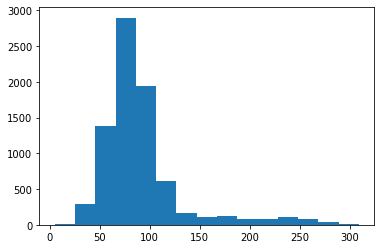

In [0]:
# For find max len 
plt.hist([len(i) for i in df1['tweet_without_stop_words']],15)
# max_len = 80 (highest length)

In [0]:
# Padding for same dimension:-
# which padding method is imp:
# https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results
df1_pad_data = pad_sequences(df1_int_data, maxlen = 80)
df1_pad_data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0, 2072, 1213,   15,   63,   40,   21,  102,   78,
         91,   84,    1], dtype=int32)

In [0]:
df_lstm = pd.DataFrame(df1_pad_data)
df_lstm['label'] = df1_new['label']
print(df_lstm.head(1))
# x_dev, x_final, y_dev, y_final = train_test_split(df_lstm.iloc[:,:-1], df_lstm['label'], test_size = 0.08, random_state = 42)
x_train, x_test, y_train, y_test = train_test_split(df_lstm.iloc[:,:-1], df_lstm['label'], test_size = 0.2, random_state = 42)
print('train shape', x_train.shape)
print('test shape', x_test.shape)

   0  1  2  3  4  5  6  7  8  9  ...  71  72  73  74   75  76  77  78  79  label
0  0  0  0  0  0  0  0  0  0  0  ...  15  63  40  21  102  78  91  84   1      0

[1 rows x 81 columns]
train shape (6336, 80)
test shape (1584, 80)


In [0]:
## Network architecture
model = Sequential()
max_fatures = 2280
maxlen = 80
model.add(Embedding(input_dim = 2280, output_dim = 100, input_length = maxlen))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) # 100 lstm units which gives 100 output
model.add(Dense(1, activation='sigmoid'))

from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[get_f1])
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 80, 100)           228000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 101       
Total params: 308,501
Trainable params: 308,501
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train, y_train, epochs = 5 , batch_size = 16, verbose = 1)

pred = model.predict(x_test)

y_pred = []
for i in pred:
  if i <= 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

print(f1_score(y_test, np.array(y_pred).reshape(y_test.shape)))
confusion_matrix(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
6336/6336 [==============================] - 26s 4ms/step - loss: 0.3353 - get_f1: 0.5757
Epoch 2/5
6336/6336 [==============================] - 26s 4ms/step - loss: 0.2115 - get_f1: 0.8022
Epoch 3/5
6336/6336 [==============================] - 26s 4ms/step - loss: 0.1774 - get_f1: 0.8490
Epoch 4/5
6336/6336 [==============================] - 26s 4ms/step - loss: 0.1569 - get_f1: 0.8674
Epoch 5/5
5040/6336 [======================>.......] - ETA: 5s - loss: 0.1310 - get_f1: 0.8875

In [0]:
###################################################

In [0]:
## MultiNaive Bayes:-
from sklearn.naive_bayes import MultinomialNB
l = [0.2, 0.3 , 0.35, 0.4, 0.45, 0.5, 0.6, 0.7]
for num in l:
  model = MultinomialNB(alpha = num)
  model.fit(x_train.iloc[:,:-1], y_train)
  pred = model.predict(x_test.iloc[:,:-1])
  y_pred = []
  for i in pred:
    if i <= 0.5:
      y_pred.append(0)
    else:
      y_pred.append(1)
  print(num, f1_score(y_test, np.array(y_pred).reshape(y_test.shape)))

#0.8168, alpha = 4

0.2 0.8185654008438819
0.3 0.8168421052631579
0.35 0.8168421052631579
0.4 0.8168421052631579
0.45 0.8168421052631579
0.5 0.8160676532769555
0.6 0.8185654008438819
0.7 0.8185654008438819


In [0]:
# It's a Over fitted algoritham We can use it, IT's goving 0.68 f1 score at Test set
model = MultinomialNB(alpha = 0.4)
model.fit(x_train.iloc[:,:-1], y_train)
pred = model.predict(x_test.iloc[:,:-1])
y_pred = []
for i in pred:
  if i <= 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)
print(f1_score(y_test, np.array(y_pred).reshape(y_test.shape)))

0.8168421052631579


In [0]:
x_test.iloc[:,:-1].shape

(792, 2278)

In [0]:
model.get_output_at(-1)

<tf.Tensor 'dense_66/Sigmoid:0' shape=(None, 1) dtype=float32>

In [0]:
## Test Data:-

In [0]:
df_test = pd.read_csv('test_sentiment-analytic.csv')
id_ = df_test['id']
df_test.drop('id', axis = 1, inplace = True)
df_test.shape

(1953, 1)

In [0]:
def punch(x):
    x = re.sub(r"[-()\"#/@;:@*<>{}`ð'+=~£|¦â.!%+-^$?,0-9]","", x)
    x = re.sub('$&@*#', 'vulgar', x) # Mention in data 
    x = re.sub(r"(\d+)(k)", r"\g<1>000", x) #expand 'k' to '000' eg. 50k to 50000
    x = re.sub("\\n", ' ', x)
    x = re.sub("\W", ' ', x)
    x = re.sub("\'s", " ", x) 
    x = re.sub("whats", "what is", x, flags=re.IGNORECASE)
    x = re.sub("\'ve", "have", x)
    x = re.sub("can't", "can not", x)
    x = re.sub("n't", "not", x)
    x = re.sub("i'm", "i am", x, flags = re.IGNORECASE)
    x = re.sub("\'re", "are", x)
    x = re.sub("\'d", "would", x)
    x = re.sub(r"http\S+", "", str(x))
    x = re.sub("e\.g\.", "eg", x, flags = re.IGNORECASE)
    x = re.sub("e-mail", "email", x, flags = re.IGNORECASE)
    x = re.sub(r"e - mail", "email", x)
    x = re.sub(r"US", "America", x)
    x = re.sub(r"USA", "America", x)
    x = re.sub(r"us", "America", x)
    x = re.sub(r"usa", "America", x)
    x = re.sub(r"Chinese", "China", x)
    x = re.sub(r"india", "India", x)
    x = re.sub("im", "i am", x, flags = re.IGNORECASE)
    x = re.sub("its", "it is", x, flags= re.IGNORECASE)
    x = re.sub("shes", "she is", x, flags = re.IGNORECASE)
    x = re.sub("u", "you", x, flags = re.IGNORECASE)
    x = re.sub("ur", "you are", x, flags = re.IGNORECASE)
    x = re.sub("wouldnt", "would not", x, flags = re.IGNORECASE)
    x = re.sub("youve",  "you have", x, flags = re.IGNORECASE)
    x = re.sub(r"\s{2,}", " ", x) # Remove extra space between words
    x = x.strip() # Remove extra space from begning and ending
    
    return(x)

def remove_stopwords(x):
    return(' '.join([word for word in nltk.word_tokenize(x) if word not in stopwords.words('english')]))

def get_char_length_ratio(x): #To find how much word has meaningful content
    return len(x['tweet'])/max(1,len(x['tweet_without_stop_words']))

def get_Levenshtein(string1,string2): # Calculate Levenshtein distance to measure similiarity between string(edit base)
    import editdistance
    return editdistance.eval(string1,string2)

############################################################
df_test['tweet'] = df_test['tweet'].map(lambda x : punch(x))
df_test['tweet_without_stop_words'] = df_test['tweet'].map(lambda x : remove_stopwords(x))
df_test['char_length_ratio'] = df_test.apply(lambda x : get_char_length_ratio(x), axis = 1)
df_test['leve_distance'] = df_test.apply(lambda x : get_Levenshtein(x['tweet'], x['tweet_without_stop_words']), axis = 1)

## Lexicon model based rating:-
from nltk.corpus import opinion_lexicon
pos_list = set(opinion_lexicon.positive())
neg_list = set(opinion_lexicon.negative())

sentiment = []
for x in df_test['tweet_without_stop_words']:
    marks = 0
    for j in nltk.word_tokenize(x):
        if j in pos_list:
            marks += 1
        elif j in neg_list:
            marks -= 1
    sentiment.append(marks)
df_test['lexicon_rating'] = sentiment
##############################################################

tfidf = TfidfVectorizer(stop_words = 'english', max_df = 0.99, strip_accents = 'unicode', ngram_range=(1, 1), min_df = 5) 
temp = tfidf.fit_transform(df_test['tweet'])

df1_new = pd.DataFrame(temp.toarray())
df1_new['char_length_ratio'] = df_test['char_length_ratio']
df1_new['leve_distance'] = df_test['leve_distance']
df1_new['lexicon_rating'] = df_test['lexicon_rating']
# df1_new['label'] = df_test['label']

# model.fit(x_train, y_train)


# f1_score(y_test, np.array(y_pred).reshape(y_test.shape))

In [0]:
print(df1_new.shape)
# df1_new = df1_new.iloc[:,:-1] # For MultiNaive Bayes
# df1_new.shape

(1953, 734)


In [0]:
df1_new.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,char_length_ratio,leve_distance,lexicon_rating
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.419114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.104478,7,-1


In [0]:
2279-734

1545

In [0]:
test_data = np.concatenate([np.concatenate([df1_new.iloc[:,:731].values, np.zeros((1953, 1545), dtype = np.float)],axis = 1), df1_new.iloc[:, -3:]], axis = 1)
test_data.shape

(1953, 2279)

In [0]:
pred = model.predict(test_data)

y_pred = []
for i in pred:
    if i <= 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

In [0]:
result = pd.DataFrame({'id':id_})
result['label'] = y_pred
result.to_csv('result4_test_analytic.csv', index = False)